In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Storytelling
L'obbiettivo di questa analisi è mostrare/vedere l'impatto dei cartellini rossi e gialli sul risultato delle partite e sulla performance delle squadre

In [68]:
# Load data from CSV files
games = pd.read_csv('./data/games.csv')
game_events = pd.read_csv('./data/game_events.csv')

## Crazione tabella 
per comodità creiamo un nuovo file che contenga le informazioni che ci interessano per fare le nostre considerazioni:
il numero di cartellini ricevuti, il numero di goal fatti e ricevuti e il risultato della partita

In [69]:
# funzione per contare il numero di cartellini ricevuti da una squadra durante una certa partita
def count_cards(game_id, club_id):
    events = game_events[(game_events['game_id'] == game_id) & (game_events['club_id'] == club_id)]
    yellow_cards = len(events[events['type'] == 'Cards'])
    return yellow_cards 

# Creiamo il nuovo dataframe che contenga i dati sopra citati
transformed_games = []

# Transform the games data
for index, row in games.iterrows():
    home_row = {
        'game_id': row['game_id'],
        'club_id': row['home_club_id'],
        'date': row['date'],
        'competition_id': row['competition_id'],
        'season': row['season'],
        'round': row['round'],
        'goals_ricevuti': row['away_club_goals'],
        'goals_fatti': row['home_club_goals'],
        'numero_di_cartellini': count_cards(row['game_id'], row['home_club_id']),
        'is_win': 1 if row['home_club_goals'] > row['away_club_goals'] else (0 if row['home_club_goals'] < row['away_club_goals'] else -1)
    }
    
    away_row = {
        'game_id': row['game_id'],
        'club_id': row['away_club_id'],
        'date': row['date'],
        'competition_id': row['competition_id'],
        'season': row['season'],
        'round': row['round'],
        'goals_ricevuti': row['home_club_goals'],
        'goals_fatti': row['away_club_goals'],
        'numero_di_cartellini': count_cards(row['game_id'], row['away_club_id']),
        'is_win': 1 if row['away_club_goals'] > row['home_club_goals'] else (0 if row['away_club_goals'] < row['home_club_goals'] else -1)
    }
    
    transformed_games.append(home_row)
    transformed_games.append(away_row)

# Convertiamo la struttura in un dataframe di panda e salviamolo in un nuovo csv
transformed_games_df = pd.DataFrame(transformed_games)

transformed_games_df.to_csv('transformed_games.csv', index=False)

In [60]:
games_df = pd.read_csv('./data/transformed_games.csv')


## Data Cleaning:

### 1) Distribuzione dei valori di numero_cartellini:

In [70]:
# Intanto vediamo qual'è la distribuzione del numero di cartellini 
print(f' Massimo e minimo tra i valori di numero_di_cartellini: \n {games_df['numero_di_cartellini'].min()} {games_df['numero_di_cartellini'].max()}')

# Vediamo che il massimo è 11 cartellini, che essendo veramente tanti sarebbe meglio controllare il numero di record per ciascun valore 
(games_df['numero_di_cartellini']).value_counts().sort_index()

# Vediamo che il numero di record con un valore di numero cartellini compreso tra 5 e 11 è davvero basso. Ciò potrebbe portare a risultati fallati. 
# Potrebbe essere una buona idea raggruppare i valori maggiori di 4 in un unica etichetta '5+'
games_df['numero_di_cartellini'] = games_df['numero_di_cartellini'].apply(lambda x: 5 if x >= 5 else x)
(games_df['numero_di_cartellini']).value_counts().sort_index()


 Massimo e minimo tra i valori di numero_di_cartellini: 
 0 5


numero_di_cartellini
0    105375
1      6872
2      7440
3      5522
4      3070
5      2153
Name: count, dtype: int64

# Analisi:

 La prima cosa che possiamo considerare è la differenza di probabilità di sconfitta in base al numero di cartellini ricevuti 
 Per poter visualizzare questa eventualità utilizzeremo una heatmap per mettere in relazione la probabilità di sconfitta con il numero di cartellini ricevuti

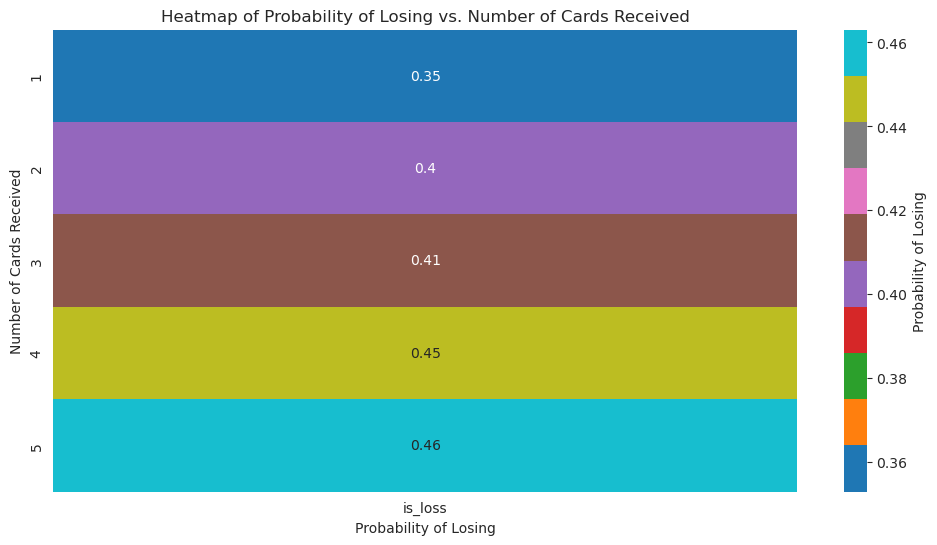

In [65]:
# Filtrare le partite con numero di cartellini maggiore di 0
games_with_cards = (games_df[games_df['numero_di_cartellini'] > 0]).copy()

games_with_cards.loc[:, 'is_loss'] = games_with_cards['is_win'].apply(lambda x: 1 if x == 0 else 0) # per semplicità aggiungiamo una colona is_loss

# contiene come index il numero di cartellini e come valore la probabilità di sconfitta
pivot_table = games_with_cards.pivot_table(values='is_loss', index='numero_di_cartellini', aggfunc='mean') 

plt.figure(figsize=(12, 6))
sns.color_palette("hls", 8)
sns.heatmap(pivot_table, annot=True, cmap='tab10', cbar_kws={'label': 'Probability of Losing'})
plt.title('Heatmap of Probability of Losing vs. Number of Cards Received')
plt.xlabel('Probability of Losing')
plt.ylabel('Number of Cards Received')
plt.show()


Sembra effettivamente che la probabilità di sconfitta aumenti all'aumentare dell'numero di cartellini